In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.optim import Optimizer
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F

import sklearn
import sklearn.metrics

/data/home/eegorova/.conda/envs/sat/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
X_train = pd.read_csv('X_train_2.csv').drop(columns='Unnamed: 0')
X_test = pd.read_csv('X_test_2.csv').drop(columns='Unnamed: 0')
with open('dict_category_2.pkl', 'rb') as f:
    dict_category = pickle.load(f)

In [3]:
X_train.groupby(['flow_model','flow_list_of_transforms','task_id']).size().max()

1

In [11]:
# del dict_category['flow_name_type']

In [4]:
num_cols = [c for c in X_train.columns if c not in dict_category and c not in ['task_id', 'value']]
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

In [ ]:
enc = OrdinalEncoder(dtype = int)
enc.fit(X[cols])
X[cols] = enc.transform(X[cols])

### MLP with RANKNET

In [5]:
BATCH_SIZE = 32
EPOCH = 1000
NUM_WORKERS = 8
LEARNING_RATE = 0.001
device = torch.device("cpu") #mps

In [6]:
class pair_dataset(Dataset):
    def __init__(self,data, dict_category):
    
        self.data = data
        self.value = self.data['value']
        self.task_id = self.data['task_id']
        self.x1 = self.data[list(set(self.data.columns) - {'value', 'task_id'})]
        self.x1_cat = torch.tensor(np.array(self.x1[dict_category.keys()]), dtype=torch.int64) #dtype=torch.float16
        self.x1_cont = torch.tensor(np.array(self.x1[list(set(self.x1.columns) - set(dict_category.keys()))]), dtype=torch.float32) #dtype=torch.float16
        # self.x1 = torch.tensor(np.array(self.data[list(set(self.data.columns) - {'value', 'task_id'})]), dtype=torch.float32) #dtype=torch.float16
        self.y1 = np.array(self.data['value'])

        self.x2 = pd.DataFrame()
        self.y2 = np.array([])
        for i in self.data.index:
            new_row = self.data[self.data['task_id'] == self.data['task_id'][i]].drop(index=i,columns =['value','task_id']).sample(n=1)
            self.x2 = self.x2.append(new_row)
            self.y2 = np.append(self.y2, self.data['value'][new_row.index])

        self.x2_cat = torch.tensor(np.array(self.x2[dict_category.keys()]), dtype=torch.int64) #dtype=torch.float16
        self.x2_cont = torch.tensor(np.array(self.x2[list(set(self.x2.columns) - set(dict_category.keys()))]), dtype=torch.float32)
        # self.x2 = torch.tensor(np.array(self.x2), dtype=torch.float32) #dtype=torch.float16
        self.y2 = np.array(self.y2)

        self.compare = torch.tensor([1.0 if t1 > t2 else 0.0 if t1 < t2 else 0.5 for t1,t2 in zip(self.y1,self.y2)], dtype=torch.float32) #dtype=torch.float16

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.x1_cat[idx], self.x1_cont[idx], self.x2_cat[idx], self.x2_cont[idx], self.compare[idx], self.value[idx], self.task_id[idx]

In [7]:
class MLP_RankNet(nn.Module):
    def __init__(self, dim_cont, pred_dim, dict_category):
        super(MLP_RankNet, self).__init__()

        self.emb_layers = nn.ModuleList([nn.Embedding(x, min((x+1)//2,20))
                                     for x in dict_category.values()])

        
        self.dim_embs = sum([min((x+1)//2,20) for x in dict_category.values()])
        self.dim_cont = dim_cont

        self.predictor = nn.Sequential(nn.Linear(self.dim_embs+self.dim_cont, pred_dim),
                                        nn.BatchNorm1d(pred_dim),
                                        nn.ReLU(inplace=True), 
                                        nn.Linear(pred_dim, 1))

    def forward(self, x1_cat, x1_cont, x2_cat, x2_cont, t):
        x1 = torch.cat([emb_layer(x1_cat[:, i]) for i,emb_layer in enumerate(self.emb_layers)],1)
        x1 = torch.cat([x1, x1_cont], 1) 

        x2 = torch.cat([emb_layer(x2_cat[:, i]) for i,emb_layer in enumerate(self.emb_layers)],1)
        x2 = torch.cat([x2, x2_cont], 1) 

        s1 =  self.predictor (x1)
        s2 =  self.predictor (x2)   
        
        return self.ranknet_loss(s1, s2, t)
    
    def ranknet_loss(self, s1, s2, t):
        o = torch.sigmoid(s1 - s2)
        loss = (-1 * t[:, None] * o + F.softplus(o))
        return loss
    
    def get(self, x_cat, x_cont):
        x = torch.cat([emb_layer(x_cat[:, i]) for i,emb_layer in enumerate(self.emb_layers)],1)
        x = torch.cat([x, x_cont], 1) 
        return self.predictor(x)

### Metrics

In [8]:
def eval(y_pos, y_neg):
        hits1_list = []
        hits3_list = []
        hits7_list = []
        mrr_list = []
        for y_pred_neg,y_pred_pos in zip(y_neg, y_pos):
                y_pred = np.concatenate([y_pred_pos, y_pred_neg])
                ranking_list = (len(y_pred) - y_pred.argsort().argsort())
                hits1_list.append(int(any(ranking_list[:1] <= 1)))
                hits3_list.append(int(all(ranking_list[:3] <= 3)))
                hits7_list.append(int(all(ranking_list[:7] <= 7)))
                mrr_list.append(np.mean(1./(np.where(ranking_list == 1)[0]+1)))     
        return np.mean(mrr_list), np.mean(hits1_list), np.mean(hits3_list), np.mean(hits7_list)

### Train and test

In [9]:
ranknet_model = MLP_RankNet(dim_cont = len(X_train.columns)-len(dict_category.keys())-2, pred_dim = 10, dict_category=dict_category).to(device)
optimizer = torch.optim.Adam( ranknet_model.parameters(), lr=LEARNING_RATE)

train_loader=DataLoader(pair_dataset(X_train, dict_category),batch_size=BATCH_SIZE, shuffle=True)

In [10]:
log = []
ndcg = []
mrr, hits1, hits3, hits7 = [], [], [], []

EPOCH = 100
for num_epoch in tqdm(range(EPOCH)):
    ranknet_model.train()
    for train_values in train_loader:
        optimizer.zero_grad()

        x1_cat, x1_cont, x2_cat, x2_cont, t, _, _ = train_values
        x1_cat, x1_cont, x2_cat, x2_cont, t = x1_cat.to(device), x1_cont.to(device), x2_cat.to(device), x2_cont.to(device), t.to(device)

        loss = ranknet_model(x1_cat, x1_cont, x2_cat, x2_cont, t).mean()
        loss.backward()
        log.append(loss.data)
        optimizer.step()
    
    ranknet_model.eval()
    Out = dict()
    for test_values in pair_dataset(X_test, dict_category):
        x1_cat, x1_cont, _, _, _, values, task_id = test_values
        loss = ranknet_model.get(torch.unsqueeze(x1_cat, 0), torch.unsqueeze(x1_cont, 0)).detach().numpy()[0][0]

        Out[task_id] = Out.setdefault(task_id, {'pred': [], 'true': []})
        Out[task_id]['pred'].append(loss)
        Out[task_id]['true'].append(values)
    pred, true, pos, neg  = [], [], [], []
    ndcg_ = []
    for task_id in Out:
        y_pred = Out[task_id]['pred']
        y_true = Out[task_id]['true']

        y = zip(y_pred,y_true)
        y_sort = sorted(y, key=lambda x: x[1], reverse=True)

        pred_sort, true_sort = zip(*y_sort)
        y_pos = pred_sort[:len(pred_sort)//2]
        y_neg = pred_sort[len(pred_sort)//2:]

        pred.append(y_pred)
        true.append(y_true)
        pos.append(y_pos)
        neg.append(y_neg)
        ndcg_.append(sklearn.metrics.ndcg_score([y_true], [y_pred]))

    ndcg.append(np.mean(ndcg_))
    mrr_temp, hits1_temp, hits3_temp, hits7_temp = eval(np.array(pos), np.array(neg))
    mrr.append(mrr_temp)
    hits1.append(hits1_temp)
    hits3.append(hits3_temp)
    hits7.append(hits7_temp)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_4025415/1817534973.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mrr_temp, hits1_temp, hits3_temp, hits7_temp = eval(np.array(pos), np.array(neg))
  1%|          | 1/100 [00:10<17:50, 10.82s/it]/tmp/ipykernel_4025415/1817534973.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mrr_temp, hits1_temp, hits3_temp, hits7_temp = eval(np.array(pos), np.array(neg))
  2%|▏         | 2/100 [00:24<20:31, 12.56s/it]/tmp/ipykernel_4025415/1817534973.py:48: VisibleDeprecationWarning: Creating an ndarr

Text(0, 0.5, 'loss')

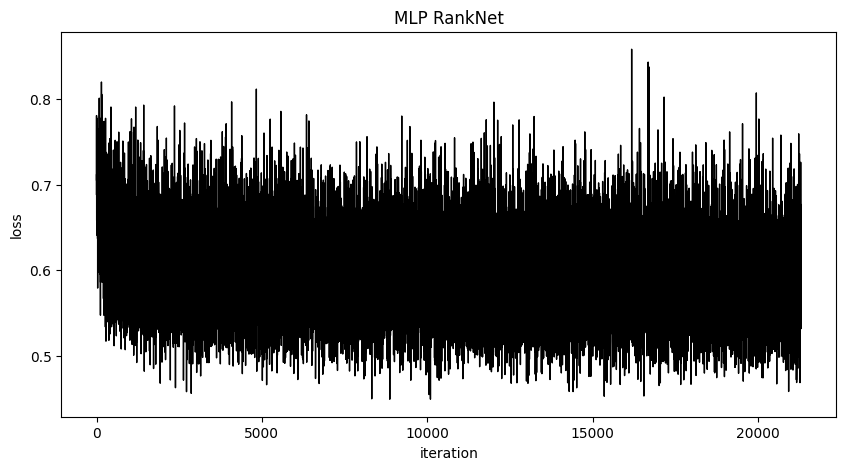

In [11]:
fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot([float(i) for i in log], color = 'black', linewidth=1)
plt.title('MLP RankNet')
plt.xlabel("iteration")
plt.ylabel("loss")

Text(0, 0.5, 'ndcg')

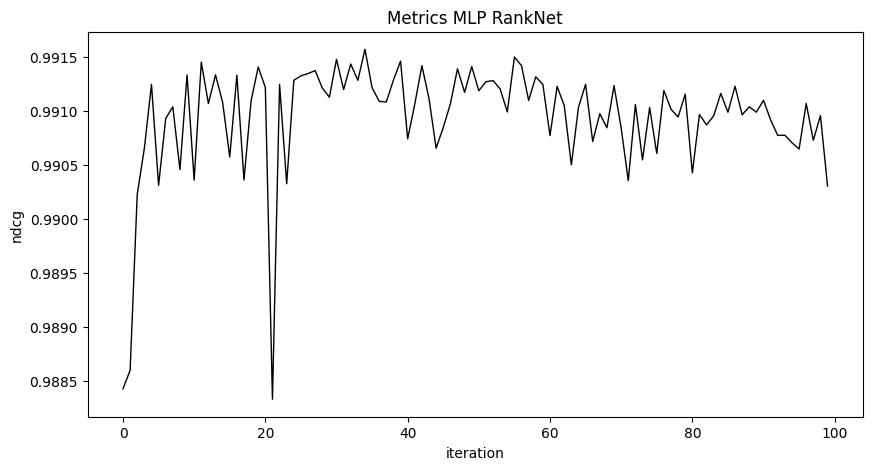

In [12]:
fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot([float(i) for i in ndcg], color = 'black', linewidth=1)
plt.title('Metrics MLP RankNet')
plt.xlabel("iteration")
plt.ylabel("ndcg")

Text(0.5, 1.0, 'HITS@7')

<Figure size 640x480 with 0 Axes>

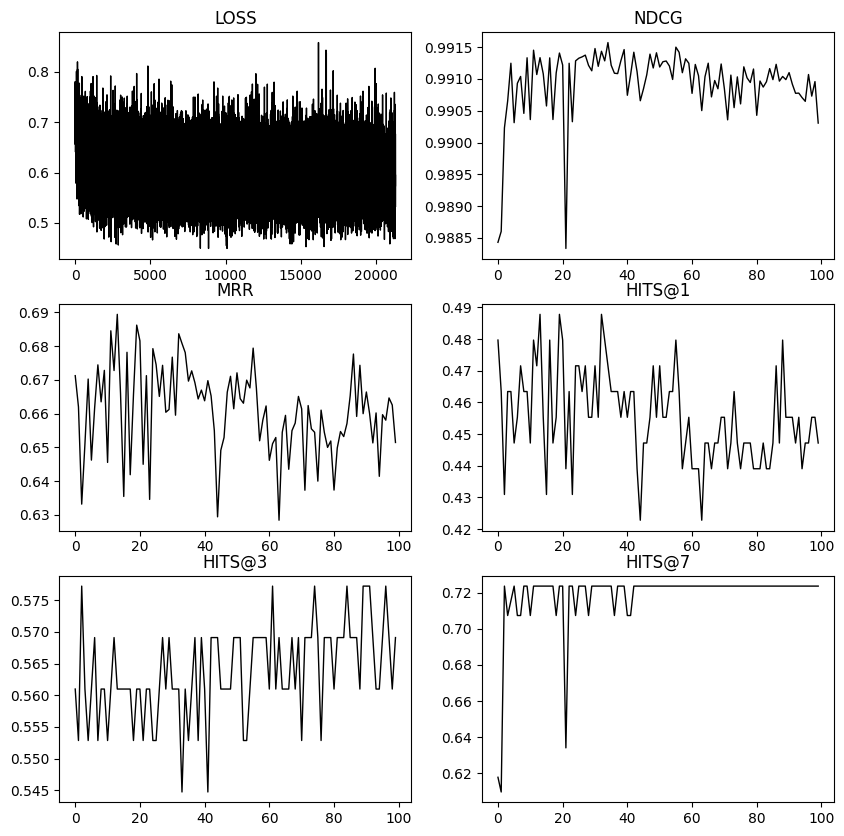

In [13]:
plt.clf()

figure, axis = plt.subplots(3, 2, figsize=(10, 10))
figure.patch.set_facecolor('xkcd:white')

axis[0,0].plot([float(i) for i in log], color = 'black', linewidth=1)
axis[0,0].set_title('LOSS')

axis[0,1].plot([float(i) for i in ndcg], color = 'black', linewidth=1)
axis[0,1].set_title("NDCG")

axis[1,0].plot(mrr, color = 'black', linewidth=1)
axis[1,0].set_title('MRR')

axis[1,1].plot(hits1, color = 'black', linewidth=1)
axis[1,1].set_title("HITS@1")

axis[2,0].plot(hits3, color = 'black', linewidth=1)
axis[2,0].set_title("HITS@3")

axis[2,1].plot(hits7, color = 'black', linewidth=1)
axis[2,1].set_title("HITS@7")

# plt.savefig(fname = "./fig/mlp_ranknet.png", dpi=300, facecolor='w', edgecolor='w',
#             orientation='portrait',pad_inches=0.1)

In [18]:
print(f'NDCG_sklearn: {round(ndcg[-1],2)}')


print()
print ('HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K')
print(f'HITS@1: {round(hits1[-1],2)}')
print(f'HITS@3: {round(hits3[-1],2)}')
print(f'HITS@7: {round(hits7[-1],2)}')
print(f'MRR: {round(mrr[-1],2)}')

NDCG_sklearn: 0.99

HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K
HITS@1: 0.44
HITS@3: 0.61
HITS@7: 0.83
MRR: 0.59
